In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
from pathlib import Path

# указывайте тот путь который у вас доступен
#train_dir = Path(your_data_path)
#test_dir = Path(your_data_path)

train_dir = Path(r'C:\Users\serez\Desktop\dataset_monkeys\training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(r'C:\Users\serez\Desktop\dataset_monkeys\validation')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

print(f"Найдено {len(train_filepaths)} обучающих изображений.")
print(f"Найдено {len(test_filepaths)} тестовых изображений.")

Найдено 1096 обучающих изображений.
Найдено 272 тестовых изображений.


In [3]:
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# датафрейм с путями к файлам и метками изображений
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Количество изображений: {train_df.shape[0]}\n')
print(f'Количество разных меток: {len(train_df.Label.unique())}\n')
print(f'Метки: {train_df.Label.unique()}')

#смотрим
train_df.head(5)

Количество изображений: 1096

Количество разных меток: 10

Метки: ['n1' 'n3' 'n4' 'n9' 'n5' 'n2' 'n7' 'n0' 'n8' 'n6']


,Filepath,Label
0,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n1
1,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n3
2,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n4
3,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n9
4,C:\Users\serez\Desktop\dataset_monkeys\trainin...,n1


In [4]:
# наименования обезьян:
name_dic = {'n0':'alouatta palliata', 
            'n1':'erythrocebus patas', 
            'n2':'cacajao calvus', 
            'n3':'macaca fuscata', 
            'n4':'cebuella pygmea', 
            'n5':'cebus capucinus', 
            'n6':'mico argentatus', 
            'n7':'saimiris ciureus', 
            'n8':'aotus nigriceps', 
            'n9':'trachypithecus johnii'}

# карта лейблов
train_df['Label'] = train_df['Label'].apply(lambda n: name_dic[n])
test_df['Label'] = test_df['Label'].apply(lambda n: name_dic[n])

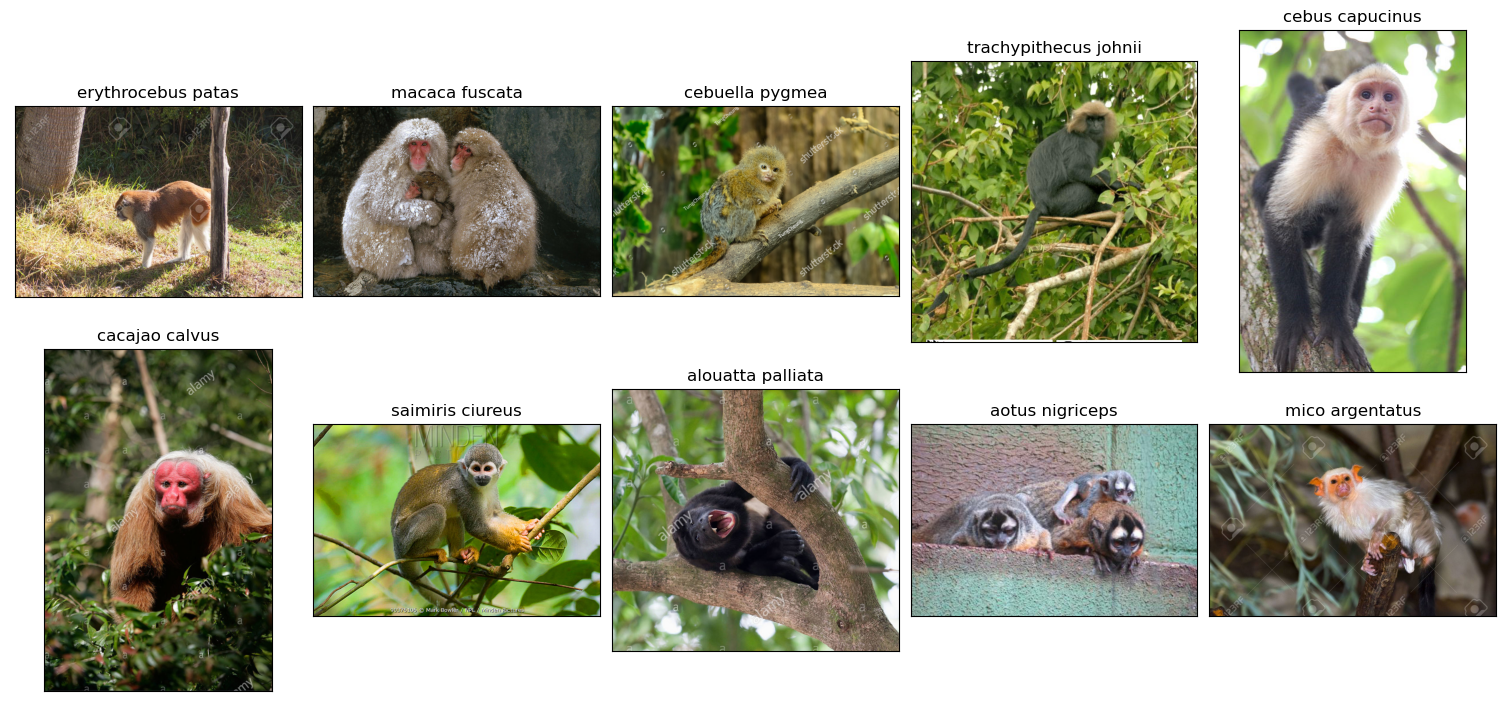

In [5]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
# генератор для тренировочных данных
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

# генератор для тестовых данных
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# генерация тренировочных данных для обучения модели
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# генерация валидационных данных для обучения модели
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# генерация тестовых данных для обучения модели

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 877 validated image filenames belonging to 10 classes.
Found 219 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


In [7]:
# используем уже пре-трейн модель
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [8]:
# входной слой модели
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# компиляция модели с использованием оптимизатора 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#обучаем
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
28/28 [==============================] - 76s 3s/step - loss: 0.7456 - accuracy: 0.7993 - val_loss: 0.0841 - val_accuracy: 0.9817
Epoch 2/50
28/28 [==============================] - 53s 2s/step - loss: 0.0440 - accuracy: 0.9909 - val_loss: 0.0903 - val_accuracy: 0.9680
Epoch 3/50
28/28 [==============================] - 54s 2s/step - loss: 0.0118 - accuracy: 0.9989 - val_loss: 0.0650 - val_accuracy: 0.9863
Epoch 4/50
28/28 [==============================] - 52s 2s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9909
Epoch 5/50
28/28 [==============================] - 54s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9909
Epoch 6/50
28/28 [==============================] - 55s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9909
Epoch 7/50
28/28 [==============================] - 57s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9909


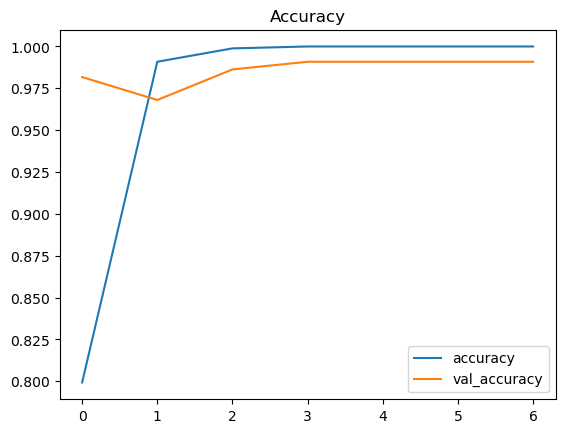

In [9]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

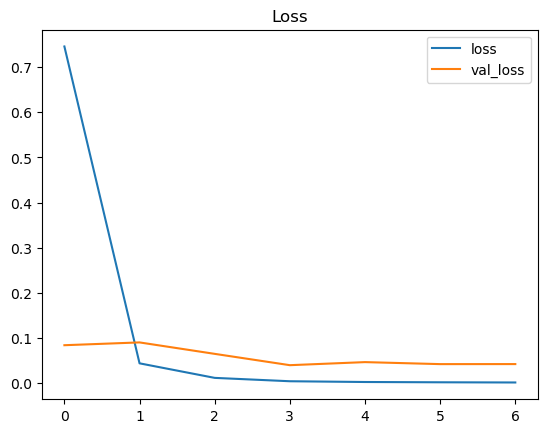

In [10]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [11]:
# предсказание 
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'Первые пять предсказаний: {pred[:5]}')

9/9 [==============================] - 16s 1s/step
Первые пять предсказаний: ['cacajao calvus', 'cebuella pygmea', 'aotus nigriceps', 'erythrocebus patas', 'macaca fuscata']


In [12]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Точность на тестовом датасете: {acc * 100:.2f}%')

Точность на тестовом датасете: 99.26%


In [13]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                       precision    recall  f1-score   support

    alouatta palliata       0.96      1.00      0.98        26
      aotus nigriceps       1.00      1.00      1.00        27
       cacajao calvus       1.00      0.96      0.98        27
      cebuella pygmea       1.00      1.00      1.00        26
      cebus capucinus       1.00      1.00      1.00        28
   erythrocebus patas       1.00      1.00      1.00        28
       macaca fuscata       1.00      1.00      1.00        30
      mico argentatus       0.96      1.00      0.98        26
     saimiris ciureus       1.00      1.00      1.00        28
trachypithecus johnii       1.00      0.96      0.98        26

             accuracy                           0.99       272
            macro avg       0.99      0.99      0.99       272
         weighted avg       0.99      0.99      0.99       272



In [14]:
# сохраняем модель в формате HDF5
model.save('model.h5')